### Introduction

$\newcommand{\G}{\mathcal{G}}$
$\newcommand{\V}{\mathcal{V}}$
$\newcommand{\E}{\mathcal{E}}$
$\newcommand{\R}{\mathbb{R}}$

This notebook shows how to apply our graph ConvNet ([paper] & [code]), or any other, to your structured or unstructured data. For this example, we assume that we have $n$ samples $x_i \in \R^{d_x}$ arranged in a data matrix $$X = [x_1, ..., x_n]^T \in \R^{n \times d_x}.$$ Each sample $x_i$ is associated with a vector $y_i \in \R^{d_y}$ for a regression task or a label $y_i \in \{0,\ldots,C\}$ for a classification task.

[paper]: https://arxiv.org/abs/1606.09375
[code]:  https://github.com/mdeff/cnn_graph

From there, we'll structure our data with a graph $\G = (\V, \E, A)$ where $\V$ is the set of $d_x = |\V|$ vertices, $\E$ is the set of edges and $A \in \R^{d_x \times d_x}$ is the adjacency matrix. That matrix represents the weight of each edge, i.e. $A_{i,j}$ is the weight of the edge connecting $v_i \in \V$ to $v_j \in \V$. The weights of that feature graph thus represent pairwise relationships between features $i$ and $j$. We call that regime **signal classification / regression**, as the samples $x_i$ to be classified or regressed are graph signals.

Other modelling possibilities include:
1. Using a data graph, i.e. an adjacency matrix $A \in \R^{n \times n}$ which represents pairwise relationships between samples $x_i \in \R^{d_x}$. The problem is here to predict a graph signal $y \in \R^{n \times d_y}$ given a graph characterized by $A$ and some graph signals $X \in \R^{n \times d_x}$. We call that regime **node classification / regression**, as we classify or regress nodes instead of signals.
2. Another problem of interest is whole graph classification, with or without signals on top. We'll call that third regime **graph classification / regression**. The problem here is to classify or regress a whole graph $A_i \in \R^{n \times n}$ (with or without an associated data matrix $X_i \in \R^{n \times d_x}$) into $y_i \in \R^{d_y}$. In case we have no signal, we can use a constant vector $X_i = 1_n$ of size $n$.

In [12]:
%load_ext autoreload
%autoreload 2

from lib import models, graph, coarsening, utils
import os, networkx, pickle, scipy, lib, time
import numpy as np, matplotlib, matplotlib.pyplot as plt, pandas as pd, tensorflow as tf
import gene_expression_modelling.parse_cmap as pcmp
from gene_expression_modelling.constants import *
from gene_expression_modelling.utils import *
import ml_toolkit.pandas_constructions as pdc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.calibration import calibration_curve
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier


plt.style.use('ggplot')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (15, 15)

In [14]:
def show_calibration(clfs):
    plt.figure(figsize=(15, 15))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in clfs:
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        elif type(clf) == lib.models.cgcnn:
            prob_pos = clf.class_probabilities(X_test_perm)
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % (name, ))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    plt.show()

# 1 Data

For the purpose of the demo, let's create a random data matrix $X \in \R^{n \times d_x}$ and somehow infer a label $y_i = f(x_i)$.

In [15]:
BASE_DATA_DIR = '/scratch/mmd/project_run_files/CEGS_clustering/data'
SUPPL_DATA_DIR = '/scratch/mmd/gene_expression_modelling/gene_expression_modelling/data'
EXP_DIR = os.path.join(BASE_DATA_DIR, 'Experiment 4 (CEGS001)/')
CTRLS = [d for d in os.listdir(EXP_DIR) if '177' in d or '179' in d or '8330' in d]
SCZS = [d for d in os.listdir(EXP_DIR) if '170' in d or '215' in d]

CORR_GRAPH_FILE = os.path.join(BASE_DATA_DIR, 'gene_self_correlation.pkl')
REG_GRAPH_FILE = os.path.join(SUPPL_DATA_DIR, 'gene_regulatory_network.pkl')

HEALTHY = 0
SCZ = 1
DX_COL = 'diagnosis'

corr_graph = depickle(CORR_GRAPH_FILE)
reg_graph = depickle(REG_GRAPH_FILE)

In [16]:
def restrict_indices(df): 
    return pdc.keep_indices(df, index_levels=['cell_id', 'pert_name', 'pert_dose'],
                            column_levels=['pr_gene_symbol'])
def get_df(d):
    base = os.path.join(EXP_DIR, d, 'by_rna_well')
    path = next((d for d in os.listdir(base) if '_COMPZ.MODZ_SCORE_LM_' in d))
    return restrict_indices(pcmp.parse(os.path.join(base, path)))

In [17]:
ctrls = pd.concat([get_df(ctrl) for ctrl in CTRLS])
ctrls[DX_COL] = HEALTHY
ctrls.set_index(DX_COL, inplace=True, append=True)
sczs = pd.concat([get_df(scz) for scz in SCZS])
sczs[DX_COL] = SCZ
sczs.set_index(DX_COL, inplace=True, append=True)

X_raw = pd.concat([ctrls, sczs])
nodelist = X_raw.columns.get_level_values('pr_gene_symbol')
X_scaled = pd.DataFrame(data=scale(X_raw.values), index=X_raw.index, columns=X_raw.columns)

/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [18]:
SG_corr = networkx.Graph([(u,v,d) for u,v,d in corr_graph.edges(data=True) if d['weight'] > 0.5])
SG_corr = SG_corr.subgraph([n for n in SG_corr.nodes() if SG_corr.neighbors(n) != []])
corr_rest_nodelist = SG_corr.nodes()

SG_reg = reg_graph.subgraph([n for n in reg_graph.nodes() if reg_graph.neighbors(n) != []])
reg_rest_nodelist = SG_reg.nodes()

nodelist = list(set(corr_rest_nodelist).intersection(reg_rest_nodelist))

SG_corr = SG_corr.subgraph([n for n in SG_corr.nodes() if n in nodelist])
SG_reg = reg_graph.subgraph([n for n in SG_reg.nodes() if n in nodelist])

In [19]:
X = X_scaled[nodelist]
dx_y = X.index.get_level_values(DX_COL)
drug_y = LabelEncoder().fit_transform(X.index.get_level_values(PERT_NAME_COL))

In [20]:
X.columns

Index(['FYN', 'TOP2A', 'WDR61', 'PEX11A', 'CRKL', 'CFLAR', 'STAMBP', 'SYK',
       'NFATC4', 'EVL',
       ...
       'GFOD1', 'PTPRK', 'ERBB3', 'XPO7', 'PPOX', 'DAG1', 'CASK', 'RNMT',
       'NRAS', 'BIRC5'],
      dtype='object', name='pr_gene_symbol', length=350)

In [21]:
y = drug_y

In [22]:
X_train, X_val, X_test, y_train, y_val, y_test = pdc.split([X, y], dev_size=0.08)

print("Train Shape: ", X_train.shape, y_train.shape)
print("Dev Shape: ", X_val.shape, y_val.shape)
print("Test Shape: ", X_test.shape, y_test.shape)

Train Shape:  (1393, 350) (1393,)
Dev Shape:  (122, 350) (122,)
Test Shape:  (379, 350) (379,)


In [23]:
n = X.shape[0]

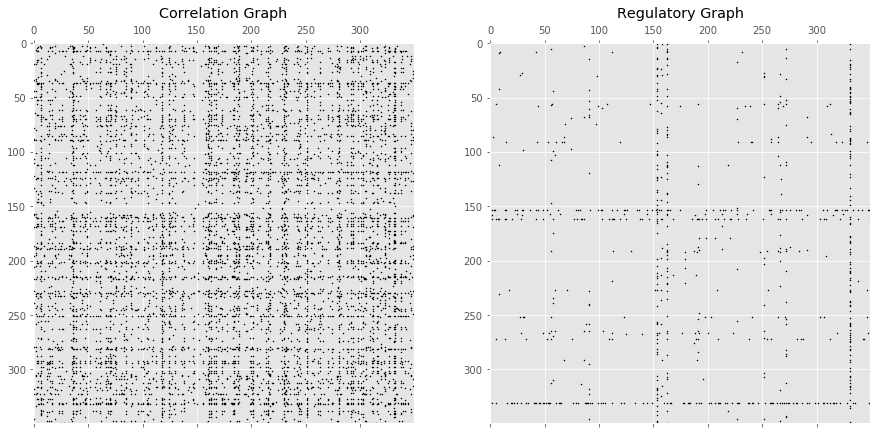

In [24]:
A_sparse_corr = networkx.adjacency_matrix(SG_corr, nodelist=X.columns).astype(np.float32)
A_sparse_reg = networkx.adjacency_matrix(SG_reg, nodelist=X.columns).astype(np.float32)

ax = plt.subplot(121)
ax.spy(A_sparse_corr, markersize=0.5, color='black')
ax.set_title('Correlation Graph')

ax = plt.subplot(122)
ax.spy(A_sparse_reg, markersize=0.5, color='black')
ax.set_title('Regulatory Graph')

plt.show()

To be able to pool graph signals, we need first to coarsen the graph, i.e. to find which vertices to group together. At the end we'll have multiple graphs, like a pyramid, each at one level of resolution. The finest graph is where the input data lies, the coarsest graph is where the data at the output of the graph convolutional layers lie. That data, of reduced spatial dimensionality, can then be fed to a fully connected layer.

The parameter here is the number of times to coarsen the graph. Each coarsening approximately reduces the size of the graph by a factor two. Thus if you want a pooling of size 4 in the first layer followed by a pooling of size 2 in the second, you'll need to coarsen $\log_2(4+2) = 3$ times.

After coarsening we rearrange the vertices (and add fake vertices) such that pooling a graph signal is analog to pooling a 1D signal. See the [paper] for details.

[paper]: https://arxiv.org/abs/1606.09375

In [26]:
graphs_corr, perm_corr = coarsening.coarsen(A_sparse_corr, levels=3, self_connections=False)
graphs_reg, perm_reg = coarsening.coarsen(A_sparse_reg, levels=3, self_connections=False)

X_train_corr = coarsening.perm_data(X_train.values, perm_corr).astype(np.float32)
X_val_corr = coarsening.perm_data(X_val.values, perm_corr).astype(np.float32)
X_test_corr = coarsening.perm_data(X_test.values, perm_corr).astype(np.float32)
X_train_reg = coarsening.perm_data(X_train.values, perm_reg).astype(np.float32)
X_val_reg = coarsening.perm_data(X_val.values, perm_reg).astype(np.float32)
X_test_reg = coarsening.perm_data(X_test.values, perm_reg).astype(np.float32)

[  0   0   0 ..., 349 349 349]
[  0   0   0 ..., 198 198 198]
[  0   0   0 ..., 101 101 101]
Layer 0: M_0 = |V| = 416 nodes (66 added),|E| = 3420 edges
Layer 1: M_1 = |V| = 208 nodes (9 added),|E| = 2841 edges
Layer 2: M_2 = |V| = 104 nodes (2 added),|E| = 1949 edges
Layer 3: M_3 = |V| = 52 nodes (0 added),|E| = 1059 edges
[  1   1   1   1   2   3   4   5   5   5   5   7   8   8   8   8   8   9
  13  13  13  14  14  14  15  17  19  20  20  22  23  24  24  24  27  27
  28  28  28  29  29  29  30  30  30  31  33  33  35  36  40  41  42  42
  42  42  43  44  44  45  46  48  48  48  48  49  51  52  52  53  53  54
  54  55  55  56  56  56  56  56  56  56  56  56  57  58  58  58  58  58
  58  58  58  59  59  59  60  60  62  63  64  64  65  66  68  68  68  69
  70  74  74  75  76  77  79  79  80  81  81  82  83  83  84  86  86  86
  86  86  87  88  88  89  90  91  91  91  91  91  91  91  91  91  91  91
  91  91  91  91  91  92  92  93  97  98  99  99  99 102 102 103 103 103
 104 104 105 107 1

/scratch/mmd/cnn_graph/lib/coarsening.py:153: RuntimeWarning: divide by zero encountered in true_divide
  tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])


In [27]:
print("Correlational Train Shape: ", X_train_corr.shape, y_train.shape)
print("Correlational Dev Shape: ", X_val_corr.shape, y_val.shape)
print("Correlational Test Shape: ", X_test_corr.shape, y_test.shape)
print("Regulatory Train Shape: ", X_train_reg.shape, y_train.shape)
print("Regulatory Dev Shape: ", X_val_reg.shape, y_val.shape)
print("Regulatory Test Shape: ", X_test_reg.shape, y_test.shape)

Correlational Train Shape:  (1393, 416) (1393,)
Correlational Dev Shape:  (122, 416) (122,)
Correlational Test Shape:  (379, 416) (379,)
Regulatory Train Shape:  (1393, 1808) (1393,)
Regulatory Dev Shape:  (122, 1808) (122,)
Regulatory Test Shape:  (379, 1808) (379,)


We finally need to compute the graph Laplacian $L$ for each of our graphs (the original and the coarsened versions), defined by their adjacency matrices $A$. The sole parameter here is the type of Laplacian, e.g. the combinatorial Laplacian, the normalized Laplacian or the random walk Laplacian.

/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


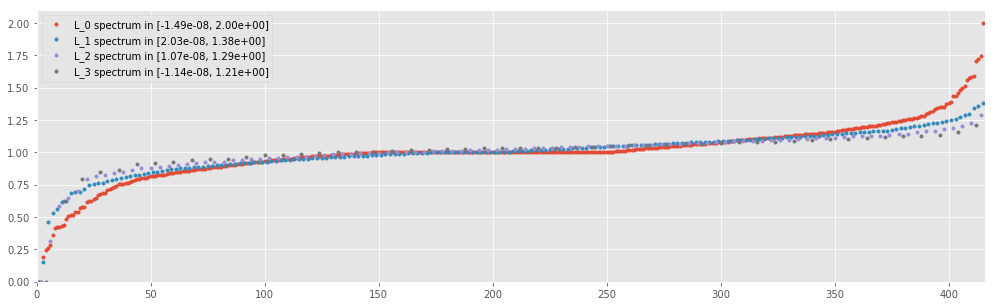

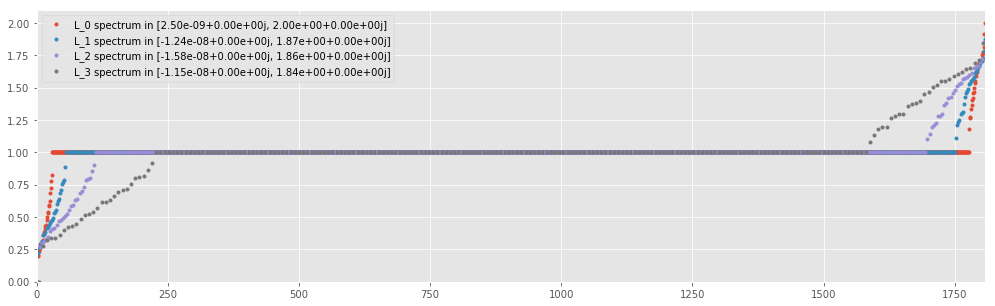

In [28]:
L_corr = [graph.laplacian(Adj, normalized=True) for Adj in graphs_corr]
L_reg = [graph.laplacian(Adj, normalized=True) for Adj in graphs_reg]
graph.plot_spectrum(L_corr)
graph.plot_spectrum(L_reg)

# Compare Classifiers

In [47]:
# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size
clfs, accs = [], {}

In [49]:
corr_params = {
    'dir_name': 'gcnn_drug_classifier_corr',
    'num_epochs': 300,
    'batch_size': 20,
    'eval_frequency': 100,

    # Building blocks.
    'filter': 'chebyshev5',
    'brelu': 'b1relu',
    'pool': 'apool1',

    # Architecture.
    'F': [10, 10],  # Number of graph convolutional filters.
    'K': [35, 35],  # Polynomial orders.
    'p': [2, 2],    # Pooling sizes.
    'M': [100, C],  # Output dimensionality of fully connected layers.

    # Optimization.
    'regularization': 1e-2,
    'dropout': 0.5,
    'learning_rate': 6e-3,
    'decay_rate': 0.98,
    'momentum': 0.9,
    'decay_steps': 2*X_train.shape[0] / 20,
}

In [50]:
reg_params = {
    'dir_name': 'gcnn_drug_classifier_reg',
    'num_epochs': 500,
    'batch_size': 20,
    'eval_frequency': 100,

    # Building blocks.
    'filter': 'chebyshev5',
    'brelu': 'b1relu',
    'pool': 'apool1',

    # Architecture.
    'F': [8, 8],  # Number of graph convolutional filters.
    'K': [40, 40],  # Polynomial orders.
    'p': [2, 2],    # Pooling sizes.
    'M': [100, C],  # Output dimensionality of fully connected layers.

    # Optimization.
    'regularization': 1e-2,
    'dropout': 0.5,
    'learning_rate': 6e-3,
    'decay_rate': 0.983,
    'momentum': 0.9,
    'decay_steps': 2*X_train.shape[0] / 20,
}

In [56]:
# Classifier Constructors
clf_constructors = [
    ('Logistic Regressor',           LogisticRegression,     {'C': 0.1},            ()),
    ('Random Forest',                RandomForestClassifier, {'n_estimators': 400}, ()),
    ('SKlearn Fully Connected ANN',  MLPClassifier,          {'alpha': 4},          ()),
    ('Correlational Graph Conv ANN', models.cgcnn,           corr_params,           (L_corr, )),
    ('Regulatory Graph Conv ANN',    models.cgcnn,           reg_params,            (L_reg, )),
#    ('Naive Bayes',                  GaussianNB,             {}),
#    ('K-neighbors',                  KNeighborsClassifier,   {'n_neighbors': 20}),
#    ('Decision Tree',                DecisionTreeClassifier, {'max_depth': 5}),
#    ('Linear SVC',                   LinearSVC,              {'C': 0.5}),
#    ('RBF SVC',                      SVC,                    {'C': 0.9, 'kernel': 'rbf'}),
#    ('AdaBoost',                     AdaBoostClassifier,     {}),
]
# Discarded Classifiers:
#38% Acc. (drug) (GaussianNB(),                                               'Naive Bayes'),
#30% Acc. (drug) (KNeighborsClassifier(n_neighbors=20),                       'K-neighbors'),
#15% Acc. (drug) (DecisionTreeClassifier(max_depth=5),                        'Decision Tree'),
#43% Acc. (drug) (LinearSVC(C=0.5),                                          'Linear Support Vector Classification'),
#34% Acc. (drug) (SVC(C=0.9),                                                 'RBF Support Vector Classification'),
#12% Acc. (drug) (AdaBoostClassifier(),                                       'AdaBoost'),
#1% Acc.  (drug) (GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True), 'Gaussian Processes'),
#3% Acc.  (drug) (QuadraticDiscriminantAnalysis(),                            'Quadratic Discriminat Analysis'),

In [60]:

def build_and_train(clf_constructors=clf_constructors, clfs_to_train='ALL', old_clfs=clfs, old_accs=accs):
    if clfs_to_train == 'ALL': clfs_to_train = range(len(clf_constructors))
    if len(clfs_to_train) == 0: return old_clfs, {}
    
    if old_clfs == []: new_clfs = [(None, 'NULL')] * len(clf_constructors)
    else: new_clfs = old_clfs
        
    new_accs = old_accs
    for idx in clfs_to_train:
        name, fn, kwargs, posargs = clf_constructors[idx]
        clf = fn(*posargs, **kwargs)
        start = time.perf_counter()
        print('Training %s' % name)
        if type(clf) == lib.models.cgcnn:
            acc = None
            if 'Regulatory' in name:
                acc = clf.fit(X_train_reg, y_train, X_val_reg, y_val)
            elif 'Correlation' in name:
                acc = clf.fit(X_train_corr, y_train, X_val_corr, y_val)
            else:
                acc = clf.fit(X_train.values, y_train, X_val.values, y_val)
            new_accs[name] = acc
        else:
            clf.fit(X_train, y_train)
        print('%s trained! Took %s' % (name, str(time.perf_counter() - start)))
        
        new_clfs[idx] = (clf, name)
        
    return new_clfs, new_accs

In [61]:
clfs, accs = build_and_train(clfs_to_train='ALL')

Training Logistic Regressor
Logistic Regressor trained! Took 4.910132437944412
Training Random Forest
Random Forest trained! Took 15.422227624803782
Training SKlearn Fully Connected ANN
SKlearn Fully Connected ANN trained! Took 3.237952284514904
NN architecture
  input: M_0 = 416
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 416 * 10 / 2 = 2080
    weights: F_0 * F_1 * K_1 = 1 * 10 * 35 = 350
    biases: F_1 = 10
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 208 * 10 / 2 = 1040
    weights: F_1 * F_2 * K_2 = 10 * 10 * 35 = 3500
    biases: F_2 = 10
  layer 3: fc1
    representation: M_3 = 100
    weights: M_2 * M_3 = 1040 * 100 = 104000
    biases: M_3 = 100
  layer 4: logits (softmax)
    representation: M_4 = 60
    weights: M_3 * M_4 = 100 * 60 = 6000
    biases: M_4 = 60
Training Correlational Graph Conv ANN
step 100 / 20895 (epoch 1.44 / 300):
  learning_rate = 6.00e-03, loss_average = 7.84e+00
  validation accuracy: 13.93 (17 / 122), f1 (weighted): 4.71, los

/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


step 200 / 20895 (epoch 2.87 / 300):
  learning_rate = 5.88e-03, loss_average = 7.21e+00
  validation accuracy: 19.67 (24 / 122), f1 (weighted): 10.43, loss: 8.05e+00
  time: 10s (wall 8s)
step 300 / 20895 (epoch 4.31 / 300):
  learning_rate = 5.76e-03, loss_average = 6.50e+00
  validation accuracy: 22.13 (27 / 122), f1 (weighted): 13.80, loss: 7.44e+00
  time: 15s (wall 12s)


/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


step 400 / 20895 (epoch 5.74 / 300):
  learning_rate = 5.76e-03, loss_average = 5.88e+00
  validation accuracy: 29.51 (36 / 122), f1 (weighted): 22.02, loss: 6.78e+00
  time: 20s (wall 15s)
step 500 / 20895 (epoch 7.18 / 300):
  learning_rate = 5.65e-03, loss_average = 5.34e+00
  validation accuracy: 31.97 (39 / 122), f1 (weighted): 26.07, loss: 6.40e+00
  time: 25s (wall 19s)
step 600 / 20895 (epoch 8.61 / 300):
  learning_rate = 5.53e-03, loss_average = 4.85e+00
  validation accuracy: 33.61 (41 / 122), f1 (weighted): 32.24, loss: 5.83e+00
  time: 31s (wall 23s)
step 700 / 20895 (epoch 10.05 / 300):
  learning_rate = 5.42e-03, loss_average = 4.49e+00
  validation accuracy: 31.97 (39 / 122), f1 (weighted): 28.38, loss: 5.77e+00
  time: 36s (wall 27s)
step 800 / 20895 (epoch 11.49 / 300):
  learning_rate = 5.42e-03, loss_average = 4.15e+00
  validation accuracy: 37.70 (46 / 122), f1 (weighted): 36.51, loss: 5.27e+00
  time: 41s (wall 31s)
step 900 / 20895 (epoch 12.92 / 300):
  learning

step 4700 / 20895 (epoch 67.48 / 300):
  learning_rate = 3.08e-03, loss_average = 9.65e-01
  validation accuracy: 40.16 (49 / 122), f1 (weighted): 39.79, loss: 4.08e+00
  time: 241s (wall 179s)
step 4800 / 20895 (epoch 68.92 / 300):
  learning_rate = 3.02e-03, loss_average = 9.79e-01
  validation accuracy: 42.62 (52 / 122), f1 (weighted): 41.24, loss: 4.07e+00
  time: 246s (wall 183s)
step 4900 / 20895 (epoch 70.35 / 300):
  learning_rate = 2.96e-03, loss_average = 9.50e-01
  validation accuracy: 40.16 (49 / 122), f1 (weighted): 39.61, loss: 4.14e+00
  time: 251s (wall 186s)
step 5000 / 20895 (epoch 71.79 / 300):
  learning_rate = 2.96e-03, loss_average = 8.60e-01
  validation accuracy: 40.98 (50 / 122), f1 (weighted): 40.55, loss: 4.03e+00
  time: 256s (wall 190s)
step 5100 / 20895 (epoch 73.22 / 300):
  learning_rate = 2.90e-03, loss_average = 9.12e-01
  validation accuracy: 42.62 (52 / 122), f1 (weighted): 42.22, loss: 4.17e+00
  time: 261s (wall 194s)
step 5200 / 20895 (epoch 74.66

step 9000 / 20895 (epoch 129.22 / 300):
  learning_rate = 1.65e-03, loss_average = 5.39e-01
  validation accuracy: 43.44 (53 / 122), f1 (weighted): 43.28, loss: 3.75e+00
  time: 457s (wall 341s)
step 9100 / 20895 (epoch 130.65 / 300):
  learning_rate = 1.61e-03, loss_average = 5.46e-01
  validation accuracy: 45.08 (55 / 122), f1 (weighted): 45.01, loss: 3.78e+00
  time: 462s (wall 345s)
step 9200 / 20895 (epoch 132.09 / 300):
  learning_rate = 1.58e-03, loss_average = 5.20e-01
  validation accuracy: 45.90 (56 / 122), f1 (weighted): 44.85, loss: 3.72e+00
  time: 468s (wall 349s)
step 9300 / 20895 (epoch 133.52 / 300):
  learning_rate = 1.58e-03, loss_average = 5.01e-01
  validation accuracy: 43.44 (53 / 122), f1 (weighted): 43.41, loss: 3.68e+00
  time: 473s (wall 353s)
step 9400 / 20895 (epoch 134.96 / 300):
  learning_rate = 1.55e-03, loss_average = 5.28e-01
  validation accuracy: 40.16 (49 / 122), f1 (weighted): 38.75, loss: 4.10e+00
  time: 478s (wall 357s)
step 9500 / 20895 (epoch 

step 13200 / 20895 (epoch 189.52 / 300):
  learning_rate = 8.98e-04, loss_average = 3.52e-01
  validation accuracy: 46.72 (57 / 122), f1 (weighted): 47.23, loss: 3.62e+00
  time: 665s (wall 500s)
step 13300 / 20895 (epoch 190.95 / 300):
  learning_rate = 8.80e-04, loss_average = 3.51e-01
  validation accuracy: 45.90 (56 / 122), f1 (weighted): 46.01, loss: 3.60e+00
  time: 670s (wall 504s)
step 13400 / 20895 (epoch 192.39 / 300):
  learning_rate = 8.63e-04, loss_average = 3.67e-01
  validation accuracy: 45.90 (56 / 122), f1 (weighted): 45.32, loss: 3.59e+00
  time: 675s (wall 507s)
step 13500 / 20895 (epoch 193.83 / 300):
  learning_rate = 8.63e-04, loss_average = 3.48e-01
  validation accuracy: 45.08 (55 / 122), f1 (weighted): 45.50, loss: 3.54e+00
  time: 680s (wall 511s)
step 13600 / 20895 (epoch 195.26 / 300):
  learning_rate = 8.45e-04, loss_average = 3.54e-01
  validation accuracy: 45.90 (56 / 122), f1 (weighted): 45.93, loss: 3.52e+00
  time: 684s (wall 515s)
step 13700 / 20895 (

step 17400 / 20895 (epoch 249.82 / 300):
  learning_rate = 4.90e-04, loss_average = 2.92e-01
  validation accuracy: 42.62 (52 / 122), f1 (weighted): 42.00, loss: 3.49e+00
  time: 871s (wall 658s)
step 17500 / 20895 (epoch 251.26 / 300):
  learning_rate = 4.80e-04, loss_average = 2.84e-01
  validation accuracy: 45.90 (56 / 122), f1 (weighted): 45.90, loss: 3.51e+00
  time: 876s (wall 661s)
step 17600 / 20895 (epoch 252.69 / 300):
  learning_rate = 4.71e-04, loss_average = 2.76e-01
  validation accuracy: 45.90 (56 / 122), f1 (weighted): 44.93, loss: 3.45e+00
  time: 881s (wall 665s)
step 17700 / 20895 (epoch 254.13 / 300):
  learning_rate = 4.61e-04, loss_average = 2.84e-01
  validation accuracy: 45.08 (55 / 122), f1 (weighted): 44.36, loss: 3.55e+00
  time: 886s (wall 669s)
step 17800 / 20895 (epoch 255.56 / 300):
  learning_rate = 4.61e-04, loss_average = 2.90e-01
  validation accuracy: 43.44 (53 / 122), f1 (weighted): 43.71, loss: 3.57e+00
  time: 891s (wall 673s)
step 17900 / 20895 (

step 400 / 34825 (epoch 5.74 / 500):
  learning_rate = 5.80e-03, loss_average = 1.19e+01
  validation accuracy: 28.69 (35 / 122), f1 (weighted): 26.58, loss: 1.39e+01
  time: 21s (wall 18s)
step 500 / 34825 (epoch 7.18 / 500):
  learning_rate = 5.70e-03, loss_average = 1.07e+01
  validation accuracy: 31.97 (39 / 122), f1 (weighted): 29.31, loss: 1.26e+01
  time: 26s (wall 22s)
step 600 / 34825 (epoch 8.61 / 500):
  learning_rate = 5.60e-03, loss_average = 9.50e+00
  validation accuracy: 34.43 (42 / 122), f1 (weighted): 32.01, loss: 1.15e+01
  time: 32s (wall 27s)
step 700 / 34825 (epoch 10.05 / 500):
  learning_rate = 5.51e-03, loss_average = 8.72e+00
  validation accuracy: 31.97 (39 / 122), f1 (weighted): 31.39, loss: 1.08e+01
  time: 37s (wall 31s)
step 800 / 34825 (epoch 11.49 / 500):
  learning_rate = 5.51e-03, loss_average = 8.00e+00
  validation accuracy: 35.25 (43 / 122), f1 (weighted): 34.77, loss: 1.01e+01
  time: 42s (wall 35s)
step 900 / 34825 (epoch 12.92 / 500):
  learning

step 4700 / 34825 (epoch 67.48 / 500):
  learning_rate = 3.41e-03, loss_average = 1.64e+00
  validation accuracy: 39.34 (48 / 122), f1 (weighted): 40.55, loss: 4.57e+00
  time: 242s (wall 205s)
step 4800 / 34825 (epoch 68.92 / 500):
  learning_rate = 3.35e-03, loss_average = 1.58e+00
  validation accuracy: 40.98 (50 / 122), f1 (weighted): 41.67, loss: 4.53e+00
  time: 247s (wall 210s)
step 4900 / 34825 (epoch 70.35 / 500):
  learning_rate = 3.29e-03, loss_average = 1.54e+00
  validation accuracy: 42.62 (52 / 122), f1 (weighted): 42.04, loss: 4.55e+00
  time: 253s (wall 214s)
step 5000 / 34825 (epoch 71.79 / 500):
  learning_rate = 3.29e-03, loss_average = 1.50e+00
  validation accuracy: 42.62 (52 / 122), f1 (weighted): 41.55, loss: 4.34e+00
  time: 258s (wall 218s)
step 5100 / 34825 (epoch 73.22 / 500):
  learning_rate = 3.24e-03, loss_average = 1.50e+00
  validation accuracy: 42.62 (52 / 122), f1 (weighted): 42.37, loss: 4.43e+00
  time: 263s (wall 223s)
step 5200 / 34825 (epoch 74.66

step 9000 / 34825 (epoch 129.22 / 500):
  learning_rate = 2.00e-03, loss_average = 9.43e-01
  validation accuracy: 40.16 (49 / 122), f1 (weighted): 38.70, loss: 4.64e+00
  time: 456s (wall 392s)
step 9100 / 34825 (epoch 130.65 / 500):
  learning_rate = 1.97e-03, loss_average = 9.86e-01
  validation accuracy: 38.52 (47 / 122), f1 (weighted): 37.70, loss: 4.29e+00
  time: 460s (wall 396s)
step 9200 / 34825 (epoch 132.09 / 500):
  learning_rate = 1.94e-03, loss_average = 9.08e-01
  validation accuracy: 45.08 (55 / 122), f1 (weighted): 44.40, loss: 4.58e+00
  time: 464s (wall 400s)
step 9300 / 34825 (epoch 133.52 / 500):
  learning_rate = 1.94e-03, loss_average = 9.88e-01
  validation accuracy: 40.16 (49 / 122), f1 (weighted): 38.56, loss: 4.45e+00
  time: 468s (wall 405s)
step 9400 / 34825 (epoch 134.96 / 500):
  learning_rate = 1.90e-03, loss_average = 1.11e+00
  validation accuracy: 41.80 (51 / 122), f1 (weighted): 40.05, loss: 4.41e+00
  time: 472s (wall 409s)
step 9500 / 34825 (epoch 

step 13200 / 34825 (epoch 189.52 / 500):
  learning_rate = 1.20e-03, loss_average = 7.36e-01
  validation accuracy: 42.62 (52 / 122), f1 (weighted): 41.33, loss: 4.26e+00
  time: 672s (wall 576s)
step 13300 / 34825 (epoch 190.95 / 500):
  learning_rate = 1.18e-03, loss_average = 6.88e-01
  validation accuracy: 44.26 (54 / 122), f1 (weighted): 42.00, loss: 4.34e+00
  time: 678s (wall 580s)
step 13400 / 34825 (epoch 192.39 / 500):
  learning_rate = 1.16e-03, loss_average = 6.80e-01
  validation accuracy: 39.34 (48 / 122), f1 (weighted): 39.69, loss: 4.21e+00
  time: 683s (wall 585s)
step 13500 / 34825 (epoch 193.83 / 500):
  learning_rate = 1.16e-03, loss_average = 6.75e-01
  validation accuracy: 42.62 (52 / 122), f1 (weighted): 42.53, loss: 4.44e+00
  time: 688s (wall 589s)
step 13600 / 34825 (epoch 195.26 / 500):
  learning_rate = 1.14e-03, loss_average = 6.61e-01
  validation accuracy: 46.72 (57 / 122), f1 (weighted): 47.44, loss: 4.23e+00
  time: 694s (wall 594s)
step 13700 / 34825 (

step 17400 / 34825 (epoch 249.82 / 500):
  learning_rate = 7.16e-04, loss_average = 4.87e-01
  validation accuracy: 40.98 (50 / 122), f1 (weighted): 41.42, loss: 4.30e+00
  time: 891s (wall 760s)
step 17500 / 34825 (epoch 251.26 / 500):
  learning_rate = 7.04e-04, loss_average = 5.24e-01
  validation accuracy: 43.44 (53 / 122), f1 (weighted): 42.71, loss: 4.31e+00
  time: 896s (wall 764s)
step 17600 / 34825 (epoch 252.69 / 500):
  learning_rate = 6.92e-04, loss_average = 4.85e-01
  validation accuracy: 42.62 (52 / 122), f1 (weighted): 42.47, loss: 4.31e+00
  time: 901s (wall 769s)
step 17700 / 34825 (epoch 254.13 / 500):
  learning_rate = 6.80e-04, loss_average = 5.10e-01
  validation accuracy: 42.62 (52 / 122), f1 (weighted): 43.48, loss: 4.27e+00
  time: 907s (wall 773s)
step 17800 / 34825 (epoch 255.56 / 500):
  learning_rate = 6.80e-04, loss_average = 4.89e-01
  validation accuracy: 41.80 (51 / 122), f1 (weighted): 41.74, loss: 4.36e+00
  time: 911s (wall 777s)
step 17900 / 34825 (

step 21600 / 34825 (epoch 310.12 / 500):
  learning_rate = 4.21e-04, loss_average = 3.46e-01
  validation accuracy: 44.26 (54 / 122), f1 (weighted): 43.77, loss: 3.97e+00
  time: 1108s (wall 944s)
step 21700 / 34825 (epoch 311.56 / 500):
  learning_rate = 4.21e-04, loss_average = 3.97e-01
  validation accuracy: 43.44 (53 / 122), f1 (weighted): 43.79, loss: 4.00e+00
  time: 1113s (wall 948s)
step 21800 / 34825 (epoch 312.99 / 500):
  learning_rate = 4.14e-04, loss_average = 3.24e-01
  validation accuracy: 40.98 (50 / 122), f1 (weighted): 40.94, loss: 4.10e+00
  time: 1119s (wall 952s)
step 21900 / 34825 (epoch 314.43 / 500):
  learning_rate = 4.06e-04, loss_average = 3.80e-01
  validation accuracy: 43.44 (53 / 122), f1 (weighted): 42.54, loss: 4.08e+00
  time: 1124s (wall 957s)
step 22000 / 34825 (epoch 315.87 / 500):
  learning_rate = 4.06e-04, loss_average = 4.06e-01
  validation accuracy: 40.16 (49 / 122), f1 (weighted): 40.89, loss: 4.05e+00
  time: 1129s (wall 961s)
step 22100 / 34

step 25800 / 34825 (epoch 370.42 / 500):
  learning_rate = 2.52e-04, loss_average = 3.30e-01
  validation accuracy: 43.44 (53 / 122), f1 (weighted): 43.63, loss: 3.98e+00
  time: 1329s (wall 1128s)
step 25900 / 34825 (epoch 371.86 / 500):
  learning_rate = 2.52e-04, loss_average = 3.50e-01
  validation accuracy: 44.26 (54 / 122), f1 (weighted): 43.52, loss: 3.92e+00
  time: 1334s (wall 1132s)
step 26000 / 34825 (epoch 373.30 / 500):
  learning_rate = 2.47e-04, loss_average = 2.88e-01
  validation accuracy: 42.62 (52 / 122), f1 (weighted): 42.32, loss: 3.96e+00
  time: 1339s (wall 1137s)
step 26100 / 34825 (epoch 374.73 / 500):
  learning_rate = 2.43e-04, loss_average = 3.09e-01
  validation accuracy: 43.44 (53 / 122), f1 (weighted): 42.94, loss: 3.99e+00
  time: 1344s (wall 1141s)
step 26200 / 34825 (epoch 376.17 / 500):
  learning_rate = 2.39e-04, loss_average = 2.94e-01
  validation accuracy: 43.44 (53 / 122), f1 (weighted): 43.99, loss: 3.90e+00
  time: 1350s (wall 1146s)
step 26300

step 30000 / 34825 (epoch 430.73 / 500):
  learning_rate = 1.50e-04, loss_average = 2.70e-01
  validation accuracy: 44.26 (54 / 122), f1 (weighted): 44.72, loss: 3.88e+00
  time: 1548s (wall 1312s)
step 30100 / 34825 (epoch 432.16 / 500):
  learning_rate = 1.48e-04, loss_average = 2.88e-01
  validation accuracy: 43.44 (53 / 122), f1 (weighted): 44.04, loss: 3.91e+00
  time: 1553s (wall 1316s)
step 30200 / 34825 (epoch 433.60 / 500):
  learning_rate = 1.48e-04, loss_average = 2.92e-01
  validation accuracy: 44.26 (54 / 122), f1 (weighted): 44.65, loss: 3.86e+00
  time: 1559s (wall 1321s)
step 30300 / 34825 (epoch 435.03 / 500):
  learning_rate = 1.45e-04, loss_average = 2.48e-01
  validation accuracy: 44.26 (54 / 122), f1 (weighted): 44.90, loss: 3.81e+00
  time: 1564s (wall 1325s)
step 30400 / 34825 (epoch 436.47 / 500):
  learning_rate = 1.43e-04, loss_average = 2.49e-01
  validation accuracy: 44.26 (54 / 122), f1 (weighted): 45.06, loss: 3.80e+00
  time: 1569s (wall 1330s)
step 30500

step 34200 / 34825 (epoch 491.03 / 500):
  learning_rate = 8.99e-05, loss_average = 2.35e-01
  validation accuracy: 44.26 (54 / 122), f1 (weighted): 44.90, loss: 3.83e+00
  time: 1769s (wall 1497s)
step 34300 / 34825 (epoch 492.46 / 500):
  learning_rate = 8.84e-05, loss_average = 2.53e-01
  validation accuracy: 44.26 (54 / 122), f1 (weighted): 44.90, loss: 3.85e+00
  time: 1774s (wall 1501s)
step 34400 / 34825 (epoch 493.90 / 500):
  learning_rate = 8.84e-05, loss_average = 2.49e-01
  validation accuracy: 44.26 (54 / 122), f1 (weighted): 44.62, loss: 3.84e+00
  time: 1779s (wall 1505s)
step 34500 / 34825 (epoch 495.33 / 500):
  learning_rate = 8.69e-05, loss_average = 2.28e-01
  validation accuracy: 45.08 (55 / 122), f1 (weighted): 46.40, loss: 3.84e+00
  time: 1784s (wall 1510s)
step 34600 / 34825 (epoch 496.77 / 500):
  learning_rate = 8.54e-05, loss_average = 2.23e-01
  validation accuracy: 45.08 (55 / 122), f1 (weighted): 46.40, loss: 3.83e+00
  time: 1789s (wall 1514s)
step 34700

# 4 Evaluation


The `model_perf` class in [utils.py](utils.py) can be used to compactly evaluate multiple models.

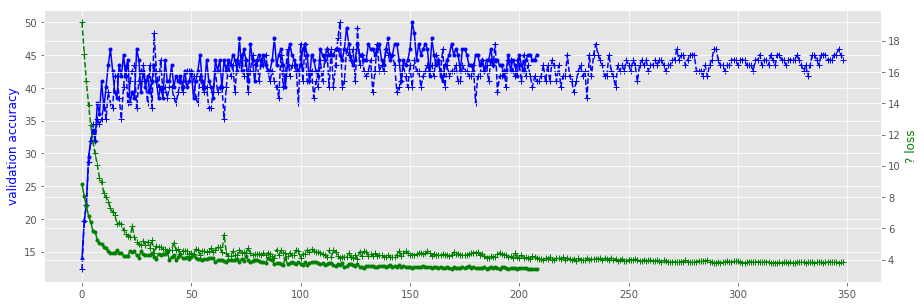

In [62]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accs['Correlational Graph Conv ANN'][0], 'b.-')
ax1.plot(accs['Regulatory Graph Conv ANN'][0], 'b+--')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(accs['Correlational Graph Conv ANN'][1], 'g.-')
ax2.plot(accs['Regulatory Graph Conv ANN'][1], 'g+--')
ax2.set_ylabel('? loss', color='g')
plt.show()

In [63]:
for clf, name in clfs:
    print(name)
    if type(clf) != lib.models.cgcnn:
        print('%.2f %%' % (100.0*clf.score(X_test, y_test)))
    elif 'Correlational' in name:
        res = clf.evaluate(X_test_corr, y_test)
        print('%.2f %%' % res[1])
    elif 'Regulatory' in name:
        res = clf.evaluate(X_test_reg, y_test)
        print('%.2f %%' % res[1])

if C == 2: calibration_curve(clfs)

Logistic Regressor
47.49 %
Random Forest
43.27 %
SKlearn Fully Connected ANN
50.40 %
Correlational Graph Conv ANN
INFO:tensorflow:Restoring parameters from /scratch/mmd/cnn_graph/lib/../checkpoints/gcnn_drug_classifier_corr/model-20895
43.80 %
Regulatory Graph Conv ANN
INFO:tensorflow:Restoring parameters from /scratch/mmd/cnn_graph/lib/../checkpoints/gcnn_drug_classifier_reg/model-34825
45.65 %
